In [17]:
## Set path
import os
from pathlib import Path

current_directory = Path.cwd()
if current_directory.name == "MT":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
    print("here")

os.chdir(root_directory)
root_directory

here


PosixPath('/home/wueesmat/MT/anomalib')

In [18]:
os.getcwd()

'/home/wueesmat/MT/anomalib'

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Import the required modules
from lightning.pytorch import Trainer, seed_everything
from anomalib.data import MVTec
from anomalib.data.image.mvtec import MVTec_contaminated
from anomalib.models import Padim, Patchcore, Stfpm, Draem, EfficientAd
from anomalib.engine import Engine
from anomalib import TaskType

In [20]:
# # Define path
# save_folder = "./results/Patchcore/"
# name = "20240409_Patchcore_test_no_refinement.npy"
# name_refined = "20240409_Patchcore_test_simple_refinement.npy"
# file_path = os.path.join(save_folder, name)
# file_path_refined = os.path.join(save_folder, name_refined)

In [27]:
#Define experiment
run_arr = np.array([2]) #np.array([1, 2, 3, 4, 5]) #np.array([1]) #np.array([42])#np.arange(3)+1
cont_ratio_arr = np.array([0.15]) #np.array([0.0, 0.05, 0.1, 0.15]) #np.array([0.0, 0.15])#np.array([0.15])#, 0.1]) #, 0.15
category_arr = np.array(["cable"])#, "grid", "leather", "tile", "wood", "bottle", "cable", "capsule", "hazelnut", "metal_nut", "pill", "screw", "toothbrush", "transistor", "zipper"])#np.array(["carpet", "grid"])#np.array(["metal_nut"])#, "grid"])# #
results_blind_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])
results_refined_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])


In [51]:
prediction_scores_blind_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])
prediction_scores_refined_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])
prediction_scores_refined_unselected_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])
abnormal_bool_blind_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])
abnormal_bool_refined_arr = np.empty([run_arr.shape[0], cont_ratio_arr.shape[0], category_arr.shape[0]])



In [ ]:
for idx_run, run in enumerate(run_arr):
    for idx_cont_ratio, cont_ratio in enumerate(cont_ratio_arr):
        for idx_category, category in enumerate(category_arr):

            ## Blind training 

            # Train on original training set
            seed_everything(run, workers=True)
            datamodule_blind = MVTec_contaminated(category=category, cont_ratio=cont_ratio, run=run, idx=[])
            model_blind = Patchcore(coreset_sampling_ratio=0.01) #Padim(backbone="resnet18", n_features=100, layers=["layer1", "layer2", "layer3"])
            engine_blind = Engine(task=TaskType.CLASSIFICATION, image_metrics=["AUROC", "AUPR", "F1Score"], max_epochs=10, devices=1)
            engine_blind.fit(datamodule=datamodule_blind, model=model_blind)

            # Evaluate on test set
            results_blind = engine_blind.test(
                model=model_blind,
                datamodule=datamodule_blind,
                ckpt_path=engine_blind.trainer.checkpoint_callback.best_model_path,
                verbose=False
            )
            results_blind_arr[idx_run, idx_cont_ratio, idx_category] = results_blind[0]["image_AUROC"]
            
            # Predict on original training set
            train_dataset_blind = datamodule_blind.get_train_dataset()
            predictions_blind = engine_blind.predict(model=model_blind, dataset=train_dataset_blind) # Make predictions on training set
            prediction_scores_blind = np.array([d["pred_scores"][0] for d in predictions_blind])#.tolist() # Get list of prediction scores
            abnormal_bool_blind = train_dataset_blind.samples_abnormal_bool[:,0]


            ## Refined training 

            # Refine training set
            sorted_indices = sorted(range(len(prediction_scores_blind)), key=lambda i: prediction_scores_blind[i]) # Sort the training samples based on prediction scores
            selected_indices = sorted_indices[:int((1-cont_ratio) * len(sorted_indices))] # Select the (1-cont_ratio)*100% lowest prediction score samples
            
            # Train on refined training set
            seed_everything(run, workers=True)
            datamodule_refined = MVTec_contaminated(category=category, cont_ratio=cont_ratio, run=run, idx=selected_indices)
            model_refined = Patchcore(coreset_sampling_ratio=0.01)
            engine_refined = Engine(task=TaskType.CLASSIFICATION, image_metrics=["AUROC", "AUPR", "F1Score"], max_epochs=10, devices=1)
            engine_refined.fit(datamodule=datamodule_refined, model=model_refined)

            # Evaluate on test set
            results_refined = engine_refined.test(
                model=model_refined,
                datamodule=datamodule_refined,
                ckpt_path=engine_refined.trainer.checkpoint_callback.best_model_path,
                verbose=False
            )
            results_refined_arr[idx_run, idx_cont_ratio, idx_category] = results_refined#[0]["image_AUROC"]

            # Predict on refined training set 
            train_dataset_refined = datamodule_refined.get_train_dataset()
            predictions_refined = engine_refined.predict(model=model_refined, dataset=train_dataset_refined)
            prediction_scores_refined = np.array([d["pred_scores"][0] for d in predictions_refined])#.tolist()
            abnormal_bool_refined = train_dataset_refined.samples_abnormal_bool[:,0]

            # Predict on refined unselected training set 
            train_dataset_refined_unselected = datamodule_refined.get_train_data_unselected()
            predictions_refined_unselected = engine_refined.predict(model=model_refined, dataset=train_dataset_refined_unselected)
            prediction_scores_refined_unselected = np.array([d["pred_scores"][0] for d in predictions_refined_unselected])#.tolist()
            abnormal_bool_refined_unselected = train_dataset_refined_unselected.samples_abnormal_bool[:,0]
            

            ## Save results
            prediction_scores_blind_arr[idx_run, idx_cont_ratio, idx_category] = prediction_scores_blind
            prediction_scores_refined_arr[idx_run, idx_cont_ratio, idx_category] = prediction_scores_refined
            prediction_scores_refined_unselected_arr[idx_run, idx_cont_ratio, idx_category] = prediction_scores_refined_unselected
            abnormal_bool_blind_arr[idx_run, idx_cont_ratio, idx_category] = abnormal_bool_blind
            abnormal_bool_refined_arr[idx_run, idx_cont_ratio, idx_category] = abnormal_bool_refined


            #results_arr_refined[idx_run, idx_cont_ratio, idx_category] = test_results_refined[0]["image_AUROC"]

#            print(run)
#            print(cont_ratio)
#            print(category)


run_arr = np.array([2]) #np.array([1, 2, 3, 4, 5]) #np.array([1]) #np.array([42])#np.arange(3)+1
cont_ratio_arr = np.array([0.15]) #np.array([0.0, 0.05, 0.1, 0.15]) #np.array([0.0, 0.15])#np.array([0.15])#, 0.1]) #, 0.15
category_arr = np.array(["cable"])#, "grid", "leather", "tile", "wood", "bottle", "cable", "capsule", "hazelnut", "metal_nut", "pill", "screw", "toothbrush", "transistor", "zipper"])#np.array(["carpet", "grid"])#np.array(["metal_nut"])#, "grid"])# #


# Save results_arr to the specified folder
results_dict = {
    "dimensions": {
        "run": run_arr,
        "cont_ratio": cont_ratio_arr,
        "category": category_arr
    },
    "results_test": {
        "predictions": test_prediction_scores,
        "metrics": test_metrics
    },
    "results_train": {
        ""
    }

    
    
    {
        "prediction_scores": test_prediction_scores_arr, 
        "metrics"
    },
    "results_train_dict": {

    }


    "prediction_scores_blind": prediction_scores_blind_arr,
    "prediction_scores_blind": prediction_scores_blind_arr,


}


## Save results_arr to the specified folder
#np.save(file_path, results_blind_arr)
#np.save(file_path_refined, results_refined_arr)


In [54]:
results_refined = engine_refined.test(
                model=model_refined,
                datamodule=datamodule_refined,
                ckpt_path=engine_refined.trainer.checkpoint_callback.best_model_path,
                verbose=False
            )
results_refined_arr[idx_run, idx_cont_ratio, idx_category] = results_refined[0]["image_AUROC"]

/home/wueesmat/anaconda3/envs/anomalib_env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Restoring states from the checkpoint path at /home/wueesmat/MT/anomalib/results/Patchcore/MVTec_contaminated/cable/v52/weights/lightning/model.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/wueesmat/MT/anomalib/results/Patchcore/MVTec_contaminated/cable/v52/weights/lightning/model.ckpt


Testing: |                                                                                                    …

In [60]:
predictions_refined_unselected

[{'image_path': ['/home/wueesmat/MT/anomalib/datasets/MVTec/cable/test/bent_wire/002.png'],
  'label': tensor([1]),
  'image': tensor([[[[-0.9245, -0.9904, -1.0555,  ..., -1.2298, -1.2104, -1.1383],
            [-0.9462, -1.0111, -1.0763,  ..., -1.1888, -1.1616, -1.1228],
            [-0.9258, -0.9799, -1.0493,  ..., -1.1253, -1.1018, -1.1082],
            ...,
            [-1.1583, -1.1498, -1.1244,  ..., -0.7958, -0.7339, -0.6239],
            [-1.1266, -1.1365, -1.1240,  ..., -0.7114, -0.6595, -0.6142],
            [-1.0881, -1.0969, -1.0532,  ..., -0.6676, -0.6230, -0.6193]],
  
           [[-0.4983, -0.6120, -0.6952,  ..., -0.9335, -0.9034, -0.7807],
            [-0.5432, -0.6329, -0.7168,  ..., -0.8460, -0.8287, -0.7523],
            [-0.5109, -0.5888, -0.6740,  ..., -0.7470, -0.7257, -0.7346],
            ...,
            [-0.7966, -0.8079, -0.7785,  ..., -0.2895, -0.1873,  0.0552],
            [-0.7533, -0.7800, -0.7757,  ..., -0.1449, -0.0539,  0.0354],
            [-0.7115, -

In [58]:
array_of_dictionaries = np.array([predictions_refined, predictions_refined], dtype=object)

In [56]:
predictions_refined

[{'image_path': ['/home/wueesmat/MT/anomalib/datasets/MVTec/cable/test/bent_wire/000.png'],
  'label': tensor([1]),
  'image': tensor([[[[-0.9576, -0.9348, -0.8388,  ..., -1.1878, -1.2013, -1.2171],
            [-0.9871, -0.9884, -0.8959,  ..., -1.2065, -1.2089, -1.1954],
            [-0.9896, -1.0452, -0.9876,  ..., -1.1679, -1.1733, -1.1370],
            ...,
            [-0.9075, -1.0167, -1.0198,  ..., -1.1774, -1.1619, -1.1171],
            [-0.9011, -0.9880, -1.0202,  ..., -1.2324, -1.1924, -1.1083],
            [-0.9242, -0.9769, -1.0319,  ..., -1.2855, -1.2240, -1.0774]],
  
           [[-0.4821, -0.4060, -0.2682,  ..., -0.8846, -0.9161, -0.9259],
            [-0.5131, -0.4752, -0.3586,  ..., -0.9007, -0.9048, -0.8767],
            [-0.5019, -0.5590, -0.4785,  ..., -0.8465, -0.8392, -0.7869],
            ...,
            [-0.4638, -0.5767, -0.5759,  ..., -0.7445, -0.7338, -0.7024],
            [-0.4401, -0.5324, -0.5777,  ..., -0.8348, -0.7839, -0.6784],
            [-0.4470, -

Text(0.5, 1.0, 'refined training, unseen testing')

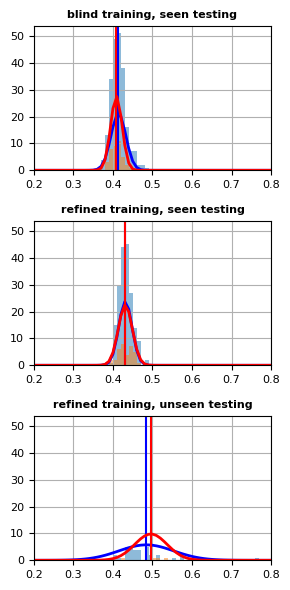

In [29]:
%matplotlib inline 
from scipy.stats import norm

# Plot metric for all categories
fontsize = 8
fig, axs = plt.subplots(3, 1, sharey=True, tight_layout=True, figsize=(3, 6))

bin_range = np.arange(0,1,0.01)

# Prepare data
dist11 = prediction_scores_blind[abnormal_bool_blind==False]
dist12 = prediction_scores_blind[abnormal_bool_blind==True]
dist21 = prediction_scores_refined[abnormal_bool_refined==False]
dist22 = prediction_scores_refined[abnormal_bool_refined==True]
dist31 = prediction_scores_refined_unselected[abnormal_bool_refined_unselected==False]
dist32 = prediction_scores_refined_unselected[abnormal_bool_refined_unselected==True]

# Plot histograms
axs[0].hist(dist11, bins=bin_range, alpha=0.5, label='Normal', density=False)
axs[0].hist(dist12, bins=bin_range, alpha=0.5, label='Abnormal', density=False)
axs[0].set_xlim([0.2,0.8])
axs[0].grid(True)
axs[0].xaxis.set_tick_params(labelsize=fontsize)
axs[0].yaxis.set_tick_params(labelsize=fontsize)

axs[1].hist(dist21, bins=bin_range, alpha=0.5, label='Normal', density=False)
axs[1].hist(dist22, bins=bin_range, alpha=0.5, label='Abnormal', density=False)
axs[1].set_xlim([0.2,0.8])
axs[1].grid(True)
axs[1].xaxis.set_tick_params(labelsize=fontsize)
axs[1].yaxis.set_tick_params(labelsize=fontsize)

axs[2].hist(dist31, bins=bin_range, alpha=0.5, label='Normal', density=False)
axs[2].hist(dist32, bins=bin_range, alpha=0.5, label='Abnormal', density=False)
axs[2].set_xlim([0.2,0.8])
axs[2].grid(True)
axs[2].xaxis.set_tick_params(labelsize=fontsize)
axs[2].yaxis.set_tick_params(labelsize=fontsize)

# Fit a normal distribution to the data
mu11, std11 = norm.fit(dist11)
mu12, std12 = norm.fit(dist12)
mu21, std21 = norm.fit(dist21)
mu22, std22 = norm.fit(dist22)
mu31, std31 = norm.fit(dist31)
mu32, std32 = norm.fit(dist32)

# Plot PDF
#xmin, xmax = axs[0].xlim()
x = bin_range
p11 = norm.pdf(x, mu11, std11)
p12 = norm.pdf(x, mu12, std12)
p21 = norm.pdf(x, mu21, std21)
p22 = norm.pdf(x, mu22, std22)
p31 = norm.pdf(x, mu31, std31)
p32 = norm.pdf(x, mu32, std32)

ymax = axs[0].get_ylim()[1]
axs[0].plot(x, p11, 'b', linewidth=2)
axs[0].vlines(mu11, ymin=0, ymax=ymax,colors='b')
axs[0].plot(x, p12, 'r', linewidth=2)
axs[0].vlines(mu12, ymin=0, ymax=ymax,colors='r')
axs[0].set_ylim([0,ymax])
axs[0].set_title("blind training, seen testing", fontsize=8, fontweight="bold")


axs[1].plot(x, p21, 'b', linewidth=2)
axs[1].vlines(mu21, ymin=0, ymax=ymax,colors='b')
axs[1].plot(x, p22, 'r', linewidth=2)
axs[1].vlines(mu22, ymin=0, ymax=ymax,colors='r')
axs[1].set_ylim([0,ymax])
axs[1].set_title("refined training, seen testing", fontsize=8, fontweight="bold")

axs[2].plot(x, p31, 'b', linewidth=2)
axs[2].vlines(mu31, ymin=0, ymax=ymax,colors='b')
axs[2].plot(x, p32, 'r', linewidth=2)
axs[2].vlines(mu32, ymin=0, ymax=ymax,colors='r')
axs[2].set_ylim([0,ymax])
axs[2].set_title("refined training, unseen testing", fontsize=8, fontweight="bold")

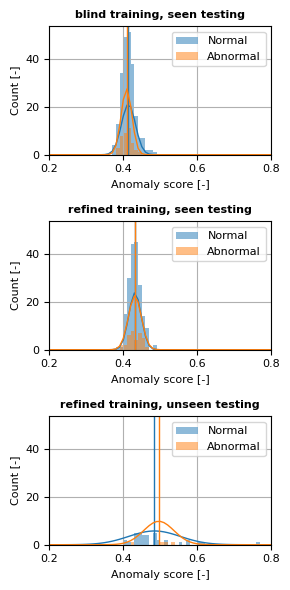

In [49]:
%matplotlib inline 
from scipy.stats import norm

# Plot metric for all categories
fontsize = 8
fig, axs = plt.subplots(3, 1, sharey=True, tight_layout=True, figsize=(3, 6))
bin_range = np.arange(0,1,0.01)

# Prepare data
dist11 = prediction_scores_blind[abnormal_bool_blind==False]
dist12 = prediction_scores_blind[abnormal_bool_blind==True]
dist21 = prediction_scores_refined[abnormal_bool_refined==False]
dist22 = prediction_scores_refined[abnormal_bool_refined==True]
dist31 = prediction_scores_refined_unselected[abnormal_bool_refined_unselected==False]
dist32 = prediction_scores_refined_unselected[abnormal_bool_refined_unselected==True]


# Fit a normal distribution to the data
x = bin_range
mu11, std11 = norm.fit(dist11)
mu12, std12 = norm.fit(dist12)
mu21, std21 = norm.fit(dist21)
mu22, std22 = norm.fit(dist22)
mu31, std31 = norm.fit(dist31)
mu32, std32 = norm.fit(dist32)
p11 = norm.pdf(x, mu11, std11)
p12 = norm.pdf(x, mu12, std12)
p21 = norm.pdf(x, mu21, std21)
p22 = norm.pdf(x, mu22, std22)
p31 = norm.pdf(x, mu31, std31)
p32 = norm.pdf(x, mu32, std32)


# Plot histograms and pdf curves
axs[0].hist(dist11, bins=bin_range, alpha=0.5, label='Normal', density=False, color='C0')
axs[0].hist(dist12, bins=bin_range, alpha=0.5, label='Abnormal', density=False, color='C1')
ymax = axs[0].get_ylim()[1]
axs[0].set_xlim([0.2,0.8])
axs[0].grid(True)
axs[0].xaxis.set_tick_params(labelsize=fontsize)
axs[0].yaxis.set_tick_params(labelsize=fontsize)
axs[0].set_xlabel("Anomaly score [-]", fontsize=fontsize)
axs[0].set_ylabel("Count [-]", fontsize=fontsize)
axs[0].legend(fontsize=fontsize)

axs[0].plot(x, p11, color='C0', linewidth=1)
axs[0].vlines(mu11, ymin=0, ymax=ymax, color='C0', linewidth=1)
axs[0].plot(x, p12, color='C1', linewidth=1)
axs[0].vlines(mu12, ymin=0, ymax=ymax, color='C1', linewidth=1)
axs[0].set_ylim([0,ymax])
axs[0].set_title("blind training, seen testing", fontsize=8, fontweight="bold")


axs[1].hist(dist21, bins=bin_range, alpha=0.5, label='Normal', density=False, color='C0')
axs[1].hist(dist22, bins=bin_range, alpha=0.5, label='Abnormal', density=False, color='C1')
axs[1].set_xlim([0.2,0.8])
axs[1].grid(True)
axs[1].xaxis.set_tick_params(labelsize=fontsize)
axs[1].yaxis.set_tick_params(labelsize=fontsize)
axs[1].set_xlabel("Anomaly score [-]", fontsize=fontsize)
axs[1].set_ylabel("Count [-]", fontsize=fontsize)
axs[1].legend(fontsize=fontsize)

axs[1].plot(x, p21, color='C0', linewidth=1)
axs[1].vlines(mu21, ymin=0, ymax=ymax, color='C0', linewidth=1)
axs[1].plot(x, p22, color='C1', linewidth=1)
axs[1].vlines(mu22, ymin=0, ymax=ymax, color='C1', linewidth=1)
axs[1].set_ylim([0,ymax])
axs[1].set_title("refined training, seen testing", fontsize=8, fontweight="bold")

axs[2].hist(dist31, bins=bin_range, alpha=0.5, label='Normal', density=False, color='C0')
axs[2].hist(dist32, bins=bin_range, alpha=0.5, label='Abnormal', density=False, color='C1')
axs[2].set_xlim([0.2,0.8])
axs[2].grid(True)
axs[2].xaxis.set_tick_params(labelsize=fontsize)
axs[2].yaxis.set_tick_params(labelsize=fontsize)
axs[2].set_xlabel("Anomaly score [-]", fontsize=fontsize)
axs[2].set_ylabel("Count [-]", fontsize=fontsize)

axs[2].plot(x, p31, color='C0', linewidth=1)
axs[2].vlines(mu31, ymin=0, ymax=ymax, color='C0', linewidth=1)
axs[2].plot(x, p32, linewidth=1, color='C1')
axs[2].vlines(mu32, ymin=0, ymax=ymax, color='C1', linewidth=1)
axs[2].set_ylim([0,ymax])
axs[2].set_title("refined training, unseen testing", fontsize=8, fontweight="bold")
axs[2].legend(fontsize=fontsize)


Text(0.5, 1.0, 'refined training, unseen testing')

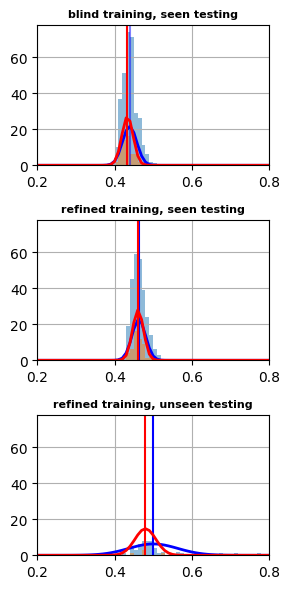

In [105]:
%matplotlib inline 
from scipy.stats import norm

# Plot metric for all categories
fontsize = 8
fig, axs = plt.subplots(3, 1, sharey=True, tight_layout=True, figsize=(3, 6))

bin_range = np.arange(0,1,0.01)

# Prepare data
dist11 = prediction_scores_blind[abnormal_bool_blind==False]
dist12 = prediction_scores_blind[abnormal_bool_blind==True]
dist21 = prediction_scores_refined[abnormal_bool_refined==False]
dist22 = prediction_scores_refined[abnormal_bool_refined==True]
dist31 = prediction_scores_refined_unselected[abnormal_bool_refined_unselected==False]
dist32 = prediction_scores_refined_unselected[abnormal_bool_refined_unselected==True]

# Plot histograms
axs[0].hist(dist11, bins=bin_range, alpha=0.5, label='Normal', density=False)
axs[0].hist(dist12, bins=bin_range, alpha=0.5, label='Abnormal', density=False)
axs[0].set_xlim([0.2,0.8])
axs[0].grid(True)
axs[0].xaxis.set_tick_params(labelsize=fontsize)
axs[0].yaxis.set_tick_params(labelsize=fontsize)

axs[1].hist(dist21, bins=bin_range, alpha=0.5, label='Normal', density=False)
axs[1].hist(dist22, bins=bin_range, alpha=0.5, label='Abnormal', density=False)
axs[1].set_xlim([0.2,0.8])
axs[1].grid(True)
axs[1].xaxis.set_tick_params(labelsize=fontsize)
axs[1].yaxis.set_tick_params(labelsize=fontsize)

axs[2].hist(dist31, bins=bin_range, alpha=0.5, label='Normal', density=False)
axs[2].hist(dist32, bins=bin_range, alpha=0.5, label='Abnormal', density=False)
axs[2].set_xlim([0.2,0.8])
axs[2].grid(True)
axs[2].xaxis.set_tick_params(labelsize=fontsize)
axs[2].yaxis.set_tick_params(labelsize=fontsize)

# Fit a normal distribution to the data
mu11, std11 = norm.fit(dist11)
mu12, std12 = norm.fit(dist12)
mu21, std21 = norm.fit(dist21)
mu22, std22 = norm.fit(dist22)
mu31, std31 = norm.fit(dist31)
mu32, std32 = norm.fit(dist32)

# Plot PDF
#xmin, xmax = axs[0].xlim()
x = bin_range
p11 = norm.pdf(x, mu11, std11)
p12 = norm.pdf(x, mu12, std12)
p21 = norm.pdf(x, mu21, std21)
p22 = norm.pdf(x, mu22, std22)
p31 = norm.pdf(x, mu31, std31)
p32 = norm.pdf(x, mu32, std32)

ymax = axs[0].get_ylim()[1]
axs[0].plot(x, p11, 'b', linewidth=2)
axs[0].vlines(mu11, ymin=0, ymax=ymax,colors='b')
axs[0].plot(x, p12, 'r', linewidth=2)
axs[0].vlines(mu12, ymin=0, ymax=ymax,colors='r')
axs[0].set_ylim([0,ymax])
axs[0].set_title("blind training, seen testing", fontsize=8, fontweight="bold")


axs[1].plot(x, p21, 'b', linewidth=2)
axs[1].vlines(mu21, ymin=0, ymax=ymax,colors='b')
axs[1].plot(x, p22, 'r', linewidth=2)
axs[1].vlines(mu22, ymin=0, ymax=ymax,colors='r')
axs[1].set_ylim([0,ymax])
axs[1].set_title("refined training, seen testing", fontsize=8, fontweight="bold")

axs[2].plot(x, p31, 'b', linewidth=2)
axs[2].vlines(mu31, ymin=0, ymax=ymax,colors='b')
axs[2].plot(x, p32, 'r', linewidth=2)
axs[2].vlines(mu32, ymin=0, ymax=ymax,colors='r')
axs[2].set_ylim([0,ymax])
axs[2].set_title("refined training, unseen testing", fontsize=8, fontweight="bold")


In [ ]:
%matplotlib inline 
from scipy.stats import norm

prediction_scores_arr = np.array(prediction_scores)
abnormal_bool = train_dataset.samples_abnormal_bool[:,0]

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
n_bins = 20
dist1 = prediction_scores_arr[abnormal_bool==False]
dist2 = prediction_scores_arr[abnormal_bool==True]

# Fit a normal distribution to the data
mu1, std1 = norm.fit(dist1)
mu2, std2 = norm.fit(dist2)


# We can set the number of bins with the *bins* keyword argument.
#axs[0].hist(dist1, bins=n_bins)
plt.hist(dist1, bins=n_bins, alpha=0.5, label='Normal', density=False)
plt.hist(dist2, bins=n_bins, alpha=0.5, label='Abnormal', density=False)
plt.xlim([0,1])

plt.legend()
#plt.title('Multiple Distributions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim([0.2, 0.6])
plt.grid(True)


# Plot PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x, mu1, std1)
plt.plot(x, p1, 'b', linewidth=2)
p2 = norm.pdf(x, mu2, std2)
plt.plot(x, p2, 'r', linewidth=2)

plt.show()


In [ ]:
train_dataset_refined

In [ ]:
datamodule_refined.get_train_dataset()

In [ ]:
train_dataset_blind.samples_abnormal_bool.shape

In [ ]:
train_dataset = datamodule.get_train_dataset()

In [ ]:
train_dataset.samples

In [ ]:
train_dataset.samples_abnormal_bool

In [ ]:
train_dataset.unselected_samples

In [ ]:
train_dataset.unselected_samples_abnormal_bool

In [ ]:
np.empty((0,0), dtype=bool)

In [ ]:
prediction_scores_arr[abnormal_bool]

In [ ]:
%matplotlib inline 
from scipy.stats import norm

prediction_scores_arr = np.array(prediction_scores)
abnormal_bool = train_dataset.samples_abnormal_bool[:,0]

#fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
dist1 = prediction_scores_arr[abnormal_bool==False]
dist2 = prediction_scores_arr[abnormal_bool==True]

# Fit a normal distribution to the data
mu1, std1 = norm.fit(dist1)
mu2, std2 = norm.fit(dist2)


# We can set the number of bins with the *bins* keyword argument.
#axs[0].hist(dist1, bins=n_bins)
plt.hist(dist1, bins=n_bins, alpha=0.5, label='Normal', density=False)
plt.hist(dist2, bins=n_bins, alpha=0.5, label='Abnormal', density=False)
plt.xlim([0,1])

plt.legend()
#plt.title('Multiple Distributions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim([0.2, 0.6])
plt.grid(True)


# Plot PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x, mu1, std1)
plt.plot(x, p1, 'b', linewidth=2)
p2 = norm.pdf(x, mu2, std2)
plt.plot(x, p2, 'r', linewidth=2)

plt.show()





In [ ]:
%matplotlib inline 
from scipy.stats import norm

prediction_scores_arr = np.array(prediction_scores)
abnormal_bool = train_dataset.samples_abnormal_bool[:,0]

#fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
dist1 = prediction_scores_arr[abnormal_bool==False]
dist2 = prediction_scores_arr[abnormal_bool==True]

# Fit a normal distribution to the data
mu1, std1 = norm.fit(dist1)
mu2, std2 = norm.fit(dist2)


# We can set the number of bins with the *bins* keyword argument.
#axs[0].hist(dist1, bins=n_bins)
plt.hist(dist1, bins=n_bins, alpha=0.5, label='Normal', density=False)
plt.hist(dist2, bins=n_bins, alpha=0.5, label='Abnormal', density=False)
plt.xlim([0,1])

plt.legend()
#plt.title('Multiple Distributions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim([0.2, 0.6])
plt.grid(True)


# Plot PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x, mu1, std1)
plt.plot(x, p1, 'b', linewidth=2)
p2 = norm.pdf(x, mu2, std2)
plt.plot(x, p2, 'r', linewidth=2)

plt.show()

In [ ]:
%matplotlib inline 
plt.hist(prediction_scores)
plt.xlim([0,1])
plt.show()

In [ ]:
prediction_scores